### Initializations

In [19]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import os
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageEnhance
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import cv2
from tensorflow.keras.utils import plot_model


### New MNIST dataset and pre-processing

In [6]:
# data: shuffled and split between train and test sets, loading and using the MNIST dataset
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [7]:
# Print the shapes of the input and output data
print("Training data input shape: " , x_train_mnist.shape)
print("Training data output shape: " , y_train_mnist.shape)
print("Test data input shape: " , x_test_mnist.shape)
print("Test data ouput shape: " , y_test_mnist.shape)

Training data input shape:  (60000, 28, 28)
Training data output shape:  (60000,)
Test data input shape:  (10000, 28, 28)
Test data ouput shape:  (10000,)


In [8]:
# Define the paths to the folders containing the additional images
additional_images_folder = "/kaggle/input/punctuation/Punct"
punctuation_folders = ["plus", "minus", "fullstop", "comma"]

additional_images_train = []
additional_labels_train = []
additional_images_test = []
additional_labels_test = []

# Load additional images from each punctuation folder
for i, folder_name in enumerate(punctuation_folders):
    folder_path = os.path.join(additional_images_folder, folder_name)
    image_files = os.listdir(folder_path)
    
    for file_name in image_files:
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path).convert("L")  # Convert to grayscale if needed
        image = image.resize((28, 28))  # Resize to match MNIST image size
        image = np.array(image)
        
        # Randomly assign images to train or test set
        if np.random.rand() < 0.8:  # 80% for training
            additional_images_train.append(image)
            additional_labels_train.append(i + 10)  # Assign unique labels for punctuation
        else:  # 20% for testing
            additional_images_test.append(image)
            additional_labels_test.append(i + 10)  # Assign unique labels for punctuation

# Convert additional train and test images and labels to NumPy arrays
additional_images_train = np.array(additional_images_train)
additional_labels_train = np.array(additional_labels_train)
additional_images_test = np.array(additional_images_test)
additional_labels_test = np.array(additional_labels_test)

# Concatenate additional train and test images and labels with the original dataset
x_train = np.concatenate([x_train_mnist, additional_images_train], axis=0)
y_train = np.concatenate([y_train_mnist, additional_labels_train], axis=0)
x_test = np.concatenate([x_test_mnist, additional_images_test], axis=0)
y_test = np.concatenate([y_test_mnist, additional_labels_test], axis=0)

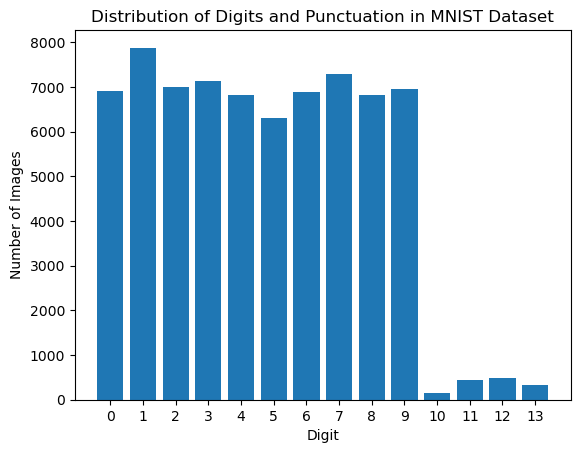

In [9]:
# Combine the training and test sets to create the entire dataset
x_mnist = np.concatenate((x_train, x_test), axis=0)
y_mnist = np.concatenate((y_train, y_test), axis=0)

# Count the occurrences of each digit in the entire dataset
digit_counts = np.bincount(y_mnist)

# Create a bar plot (histogram) to visualize the distribution
digits = np.arange(14)
plt.bar(digits, digit_counts, tick_label=digits)
plt.xlabel('Digit')
plt.ylabel('Number of Images')
plt.title('Distribution of Digits and Punctuation in MNIST Dataset')
plt.show()

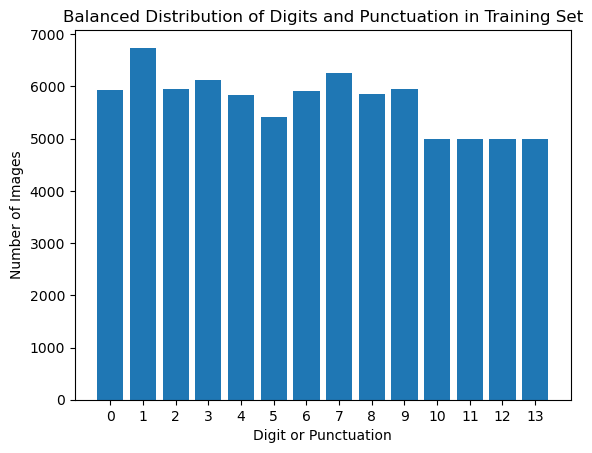

In [10]:
# Define the paths to the folders containing the additional images
additional_images_folder = "/kaggle/input/punctuation/Punct"
punctuation_folders = ["plus", "minus", "fullstop", "comma"]

additional_images = []
additional_labels = []

# Load additional images from each punctuation folder
for i, folder_name in enumerate(punctuation_folders):
    folder_path = os.path.join(additional_images_folder, folder_name)
    image_files = os.listdir(folder_path)
    
    for file_name in image_files:
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path).convert("L")  # Convert to grayscale if needed
        image = image.resize((28, 28))  # Resize to match MNIST image size
        image = np.array(image)
        
        additional_images.append(image)
        additional_labels.append(10 + i)  # Assign unique labels for punctuation

# Convert additional images and labels to NumPy arrays
additional_images = np.array(additional_images)
additional_labels = np.array(additional_labels)

# Combine the additional images with the original MNIST training set
x_train = np.concatenate([x_train_mnist, additional_images], axis=0)
y_train = np.concatenate([y_train_mnist, additional_labels], axis=0)

# Flatten the training images and labels for SMOTE
x_train_flat = x_train.reshape(x_train.shape[0], -1)
y_train_flat = y_train

# Initialize SMOTE with desired sampling strategy for punctuation classes (10 to 13)
sampling_strategy = {10: 5000, 11: 5000, 12: 5000, 13: 5000}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Apply SMOTE only to the punctuation classes (10 to 13)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train_flat, y_train_flat)

# Reshape resampled images back to their original shape
x_train_resampled = x_train_resampled.reshape(-1, 28, 28)

# Visualize the distribution after balancing
unique_labels, label_counts = np.unique(y_train_resampled, return_counts=True)
plt.bar(unique_labels, label_counts, tick_label=unique_labels)
plt.xlabel('Digit or Punctuation')
plt.ylabel('Number of Images')
plt.title('Balanced Distribution of Digits and Punctuation in Training Set')
plt.show()


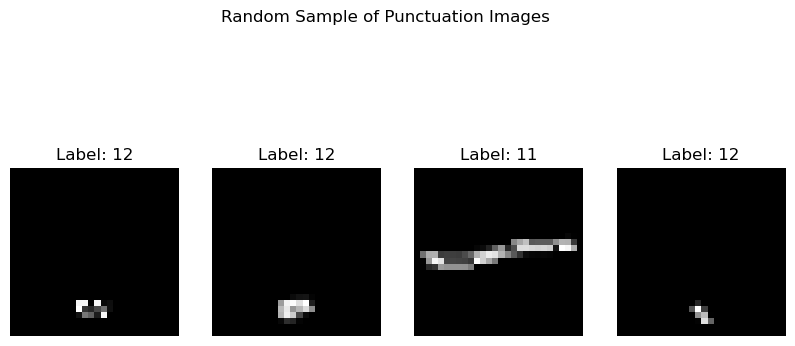

In [11]:
# Randomly select a subset of punctuation images for visualization
num_samples = 4
random_indices = np.random.choice(np.where(y_train_resampled >= 11)[0], num_samples, replace=False)
sample_images = x_train_resampled[random_indices]
sample_labels = y_train_resampled[random_indices]

# Visualize random sample images of the punctuation data
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f'Label: {sample_labels[i]}')
    plt.axis('off')
plt.suptitle('Random Sample of Punctuation Images')
plt.show()

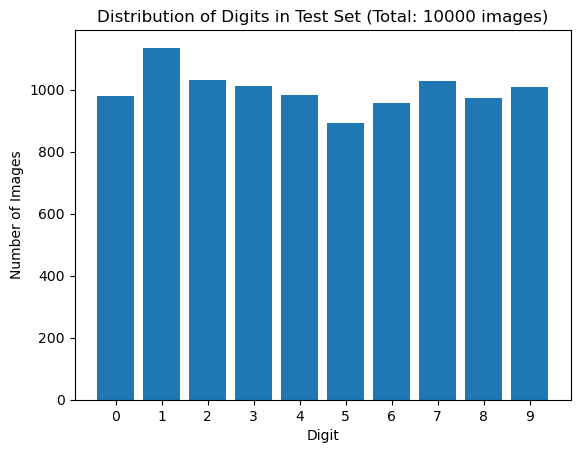

In [12]:
# Calculate the total number of images in the resampled training set
total_train_images = np.sum(label_counts)

# Flatten the test images and labels
x_test_flat = x_test_mnist.reshape(x_test_mnist.shape[0], -1)
y_test_flat = y_test_mnist

# Calculate the total number of images in the test set
total_test_images = len(y_test_flat)

# Visualize the distribution of the test set
unique_test_labels, test_label_counts = np.unique(y_test_flat, return_counts=True)
plt.bar(unique_test_labels, test_label_counts, tick_label=unique_test_labels)
plt.xlabel('Digit')
plt.ylabel('Number of Images')
plt.title(f'Distribution of Digits in Test Set (Total: {total_test_images} images)')
plt.show()

/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:314: UserWarning: After over-sampling, the number of samples (5000) in class 10 will be larger than the number of samples in the majority class (class #12 -> 486)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:314: UserWarning: After over-sampling, the number of samples (5000) in class 11 will be larger than the number of samples in the majority class (class #12 -> 486)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:314: UserWarning: After over-sampling, the number of samples (5000) in class 12 will be larger than the number of samples in the majority class (class #12 -> 486)
  f"After over-sampling, the number of samples ({n_samples})"
/opt/conda/lib/python3.7/site-packages/imblearn/utils/_validation.py:314: UserWarning: After over-sampling, the number

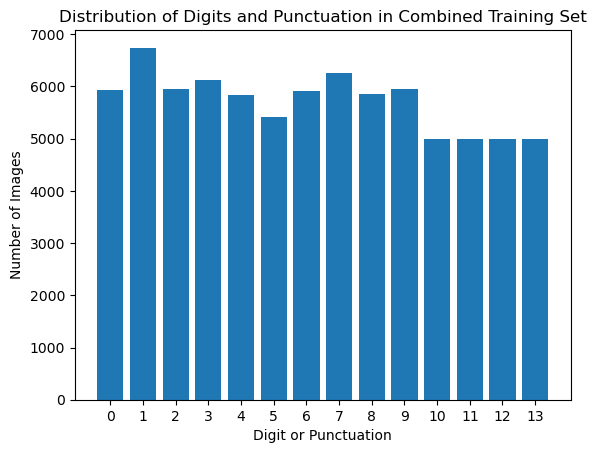

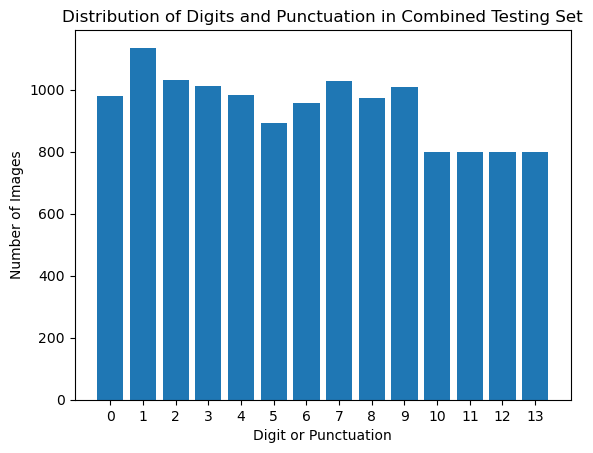

In [13]:
# Define the paths to the folders containing the additional images
additional_images_folder = "/kaggle/input/punctuation/Punct"
punctuation_folders = ["plus", "minus", "fullstop", "comma"]

additional_images = []
additional_labels = []

# Load additional images from each punctuation folder for training
for i, folder_name in enumerate(punctuation_folders):
    folder_path = os.path.join(additional_images_folder, folder_name)
    image_files = os.listdir(folder_path)
    
    for file_name in image_files:
        file_path = os.path.join(folder_path, file_name)
        image = Image.open(file_path).convert("L")  # Convert to grayscale if needed
        image = image.resize((28, 28))  # Resize to match MNIST image size
        image = np.array(image)
        
        additional_images.append(image)
        additional_labels.append(10 + i)  # Assign unique labels for punctuation

# Convert additional images and labels to NumPy arrays for training
additional_images_train = np.array(additional_images)
additional_labels_train = np.array(additional_labels)

# Flatten the additional images for SMOTE
additional_images_train_flat = additional_images_train.reshape(additional_images_train.shape[0], -1)

# Initialize SMOTE with desired sampling strategy for punctuation classes (10 to 13)
sampling_strategy_train = {10: 5000, 11: 5000, 12: 5000, 13: 5000}
smote_train = SMOTE(sampling_strategy=sampling_strategy_train, random_state=42)

# Apply SMOTE only to the punctuation classes (10 to 13) for training
additional_images_resampled_train, additional_labels_resampled_train = smote_train.fit_resample(additional_images_train_flat, additional_labels_train)

# Reshape the resampled images back to their original shape
additional_images_resampled_train_reshaped = additional_images_resampled_train.reshape(-1, 28, 28)

# Combine the resampled punctuation images with the original MNIST training set
x_train_resampled = np.concatenate([x_train_mnist, additional_images_resampled_train_reshaped], axis=0)
y_train_resampled = np.concatenate([y_train_mnist, additional_labels_resampled_train], axis=0)

# Initialize SMOTE with desired sampling strategy for punctuation classes (10 to 13) for testing
sampling_strategy_test = {10: 800, 11: 800, 12: 800, 13: 800}
smote_test = SMOTE(sampling_strategy=sampling_strategy_test, random_state=42)

# Apply SMOTE only to the punctuation classes (10 to 13) for testing
additional_images_resampled_test, additional_labels_resampled_test = smote_test.fit_resample(additional_images_train_flat, additional_labels_train)

# Reshape the resampled images back to their original shape
additional_images_resampled_test_reshaped = additional_images_resampled_test.reshape(-1, 28, 28)

# Combine the resampled punctuation images with the original MNIST testing set
x_test_resampled = np.concatenate([x_test_mnist, additional_images_resampled_test_reshaped], axis=0)
y_test_resampled = np.concatenate([y_test_mnist, additional_labels_resampled_test], axis=0)

# Visualize the distribution of the combined training set
unique_train_labels, train_label_counts = np.unique(y_train_resampled, return_counts=True)
plt.bar(unique_train_labels, train_label_counts, tick_label=unique_train_labels)
plt.xlabel('Digit or Punctuation')
plt.ylabel('Number of Images')
plt.title(f'Distribution of Digits and Punctuation in Combined Training Set')
plt.show()

# Visualize the distribution of the combined testing set
unique_test_labels, test_label_counts = np.unique(y_test_resampled, return_counts=True)
plt.bar(unique_test_labels, test_label_counts, tick_label=unique_test_labels)
plt.xlabel('Digit or Punctuation')
plt.ylabel('Number of Images')
plt.title(f'Distribution of Digits and Punctuation in Combined Testing Set')
plt.show()


In [14]:
# Convert labels to one-hot encoded format
num_classes = len(np.unique(y_train_resampled))
Y_train = to_categorical(y_train_resampled, num_classes)
Y_test = to_categorical(y_test_resampled, num_classes)

# Normalize pixel values to the range [0, 1]
X_train = x_train_resampled.astype('float32') / 255.0
X_test = x_test_resampled.astype('float32') / 255.0

In [15]:
#print the shapes of the input and output data
print("Training data input shape: " , X_train.shape)
print("Training data output shape: " , Y_train.shape)
print("Test data input shape: " , X_test.shape)
print("Test data ouput shape: " , Y_test.shape)

Training data input shape:  (80000, 28, 28)
Training data output shape:  (80000, 14)
Test data input shape:  (13200, 28, 28)
Test data ouput shape:  (13200, 14)


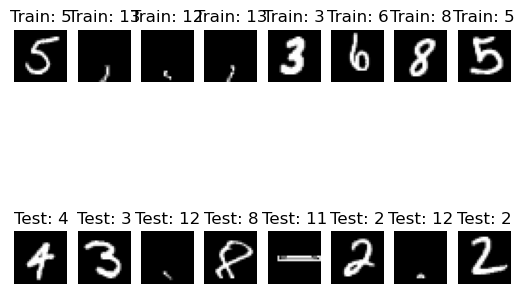

In [17]:
# Print a sample of the full dataset
num_samples = 8  # Number of samples to display
random_indices_train = np.random.choice(len(X_train), num_samples, replace=False)
random_indices_test = np.random.choice(len(X_test), num_samples, replace=False)
sample_images_train = X_train[random_indices_train]
sample_labels_train = Y_train[random_indices_train]
sample_images_test = X_test[random_indices_test]
sample_labels_test = Y_test[random_indices_test]

for i in range(num_samples):
    image_train = sample_images_train[i]
    label_train = np.argmax(sample_labels_train[i])
    image_test = sample_images_test[i]
    label_test = np.argmax(sample_labels_test[i])

    plt.subplot(2, num_samples, i+1)
    plt.imshow(image_train.squeeze(), cmap='gray')
    plt.title("Train: {}".format(label_train))
    plt.axis('off')
    
    plt.subplot(2, num_samples, num_samples+i+1)
    plt.imshow(image_test.squeeze(), cmap='gray')
    plt.title("Test: {}".format(label_test))
    plt.axis('off')

plt.show()

### CNN Baseline Experiment

In [18]:
#training constants
BATCH_SIZE = 128
N_EPOCH = 40
N_CLASSES = 14
VERBOSE = 1
VALIDATION_SPLIT = 0.2
LEARN_RATE = 0.001
OPTIM = OPTIM = Adam(learning_rate=LEARN_RATE)

print('Main variables initialised.')

Main variables initialised.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

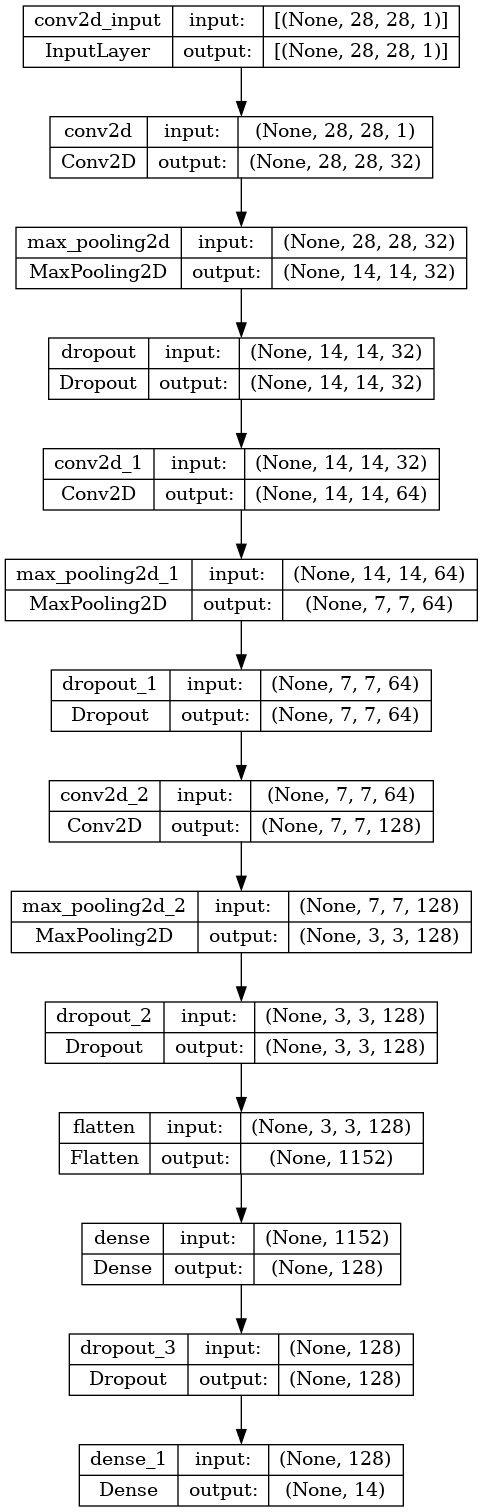

<Figure size 300x300 with 0 Axes>

In [20]:
# Network definition
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(14, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])

# Show the model summary
model.summary()

# Visualize the model architecture
plt.figure(figsize=(3, 3))
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

#### Training and Validation

In [21]:
history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

Epoch 1/40


2023-08-30 03:35:54.930957: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 13s 9ms/step - loss: 0.4471 - accuracy: 0.8572 - val_loss: 0.1700 - val_accuracy: 0.9363
Epoch 2/40
500/500 [==============================] - 5s 10ms/step - loss: 0.1244 - accuracy: 0.9629 - val_loss: 0.1109 - val_accuracy: 0.9599
Epoch 3/40
500/500 [==============================] - 5s 9ms/step - loss: 0.0893 - accuracy: 0.9730 - val_loss: 0.0563 - val_accuracy: 0.9801
Epoch 4/40
500/500 [==============================] - 4s 9ms/step - loss: 0.0746 - accuracy: 0.9783 - val_loss: 0.0666 - val_accuracy: 0.9779
Epoch 5/40
500/500 [==============================] - 4s 7ms/step - loss: 0.0649 - accuracy: 0.9808 - val_loss: 0.0308 - val_accuracy: 0.9896
Epoch 6/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0557 - accuracy: 0.9836 - val_loss: 0.0221 - val_accuracy: 0.9929
Epoch 7/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0522 - accuracy: 0.9844 - val_loss: 0.0217 - val_accuracy: 0.9931
Epoch 8/40
500/

In [22]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc)

413/413 [==============================] - 2s 5ms/step - loss: 0.0244 - accuracy: 0.9946
Test accuracy: 0.994621217250824


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


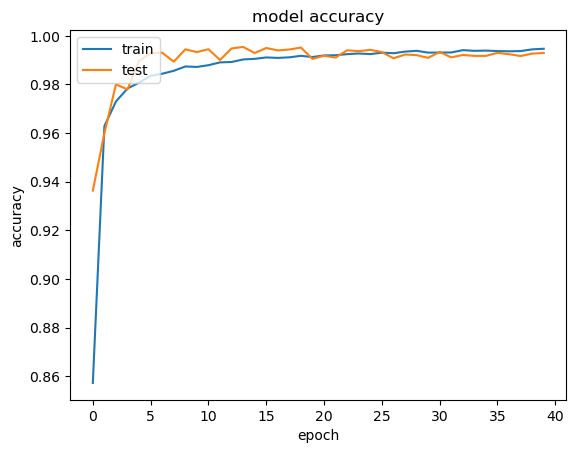

In [23]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

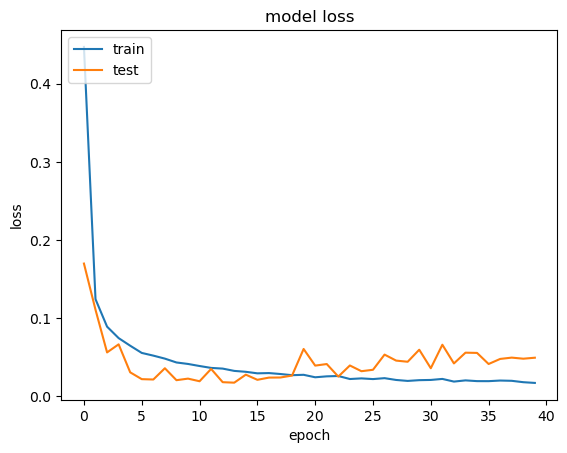

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Hyperparameter tuning

In [25]:
def create_cnn_model():
    
    # Network definition
    model = Sequential()

    # Block 1
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(14, activation='softmax'))
    
    return model

#### 1. Adam, 0.01

Main variables initialised.
Epoch 1/40
 13/500 [..............................] - ETA: 4s - loss: 2.5804 - accuracy: 0.0925

2023-08-30 03:39:40.921022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 5s 8ms/step - loss: 0.8469 - accuracy: 0.7269 - val_loss: 0.7420 - val_accuracy: 0.5322
Epoch 2/40
500/500 [==============================] - 4s 8ms/step - loss: 0.4708 - accuracy: 0.8547 - val_loss: 0.5568 - val_accuracy: 0.6648
Epoch 3/40
500/500 [==============================] - 4s 8ms/step - loss: 0.4087 - accuracy: 0.8733 - val_loss: 0.4842 - val_accuracy: 0.7052
Epoch 4/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3949 - accuracy: 0.8788 - val_loss: 0.4829 - val_accuracy: 0.6849
Epoch 5/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3830 - accuracy: 0.8809 - val_loss: 0.5188 - val_accuracy: 0.7293
Epoch 6/40
500/500 [==============================] - 4s 9ms/step - loss: 0.3781 - accuracy: 0.8838 - val_loss: 0.4268 - val_accuracy: 0.7046
Epoch 7/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3693 - accuracy: 0.8860 - val_loss: 0.5111 - val_accuracy: 0.6938
Epoch 8/40
500/50

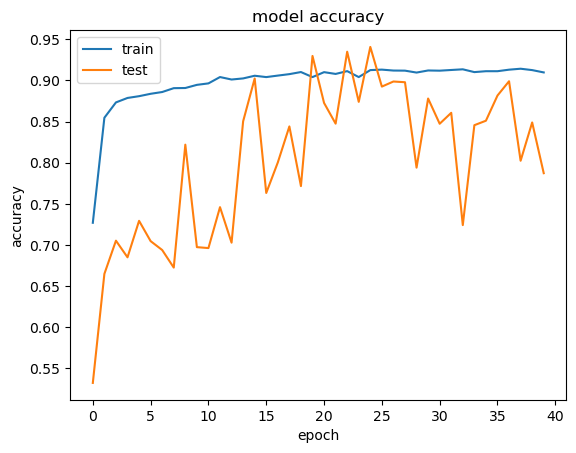

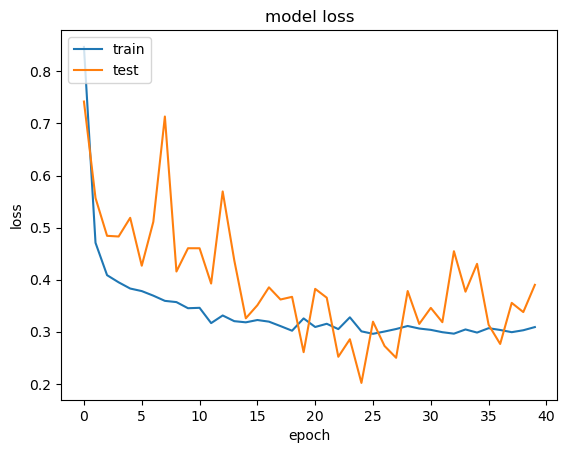

In [26]:
# Training variables
LEARN_RATE = 0.01
OPTIM = Adam(learning_rate=LEARN_RATE)

print('Main variables initialised.')

model1 = create_cnn_model()
model1.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
history1 = model1.fit(X_train, Y_train, batch_size=128, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# Evaluate the model on the test set
test_loss1, test_acc1 = model1.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc1)

# list all data in history
print(history1.history.keys())
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 2. Adam, 0.001

Main variables initialised.
Epoch 1/40
 13/500 [..............................] - ETA: 4s - loss: 2.5259 - accuracy: 0.1142

2023-08-30 03:42:25.557345: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 5s 9ms/step - loss: 0.4925 - accuracy: 0.8447 - val_loss: 0.1506 - val_accuracy: 0.9320
Epoch 2/40
500/500 [==============================] - 4s 8ms/step - loss: 0.1419 - accuracy: 0.9588 - val_loss: 0.0591 - val_accuracy: 0.9761
Epoch 3/40
500/500 [==============================] - 4s 8ms/step - loss: 0.1026 - accuracy: 0.9694 - val_loss: 0.0527 - val_accuracy: 0.9805
Epoch 4/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0825 - accuracy: 0.9763 - val_loss: 0.0589 - val_accuracy: 0.9782
Epoch 5/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0711 - accuracy: 0.9793 - val_loss: 0.0297 - val_accuracy: 0.9897
Epoch 6/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0629 - accuracy: 0.9818 - val_loss: 0.0321 - val_accuracy: 0.9888
Epoch 7/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0614 - accuracy: 0.9819 - val_loss: 0.0323 - val_accuracy: 0.9894
Epoch 8/40
500/50

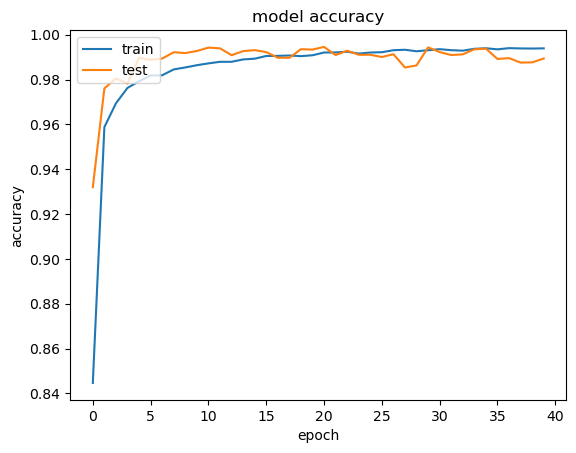

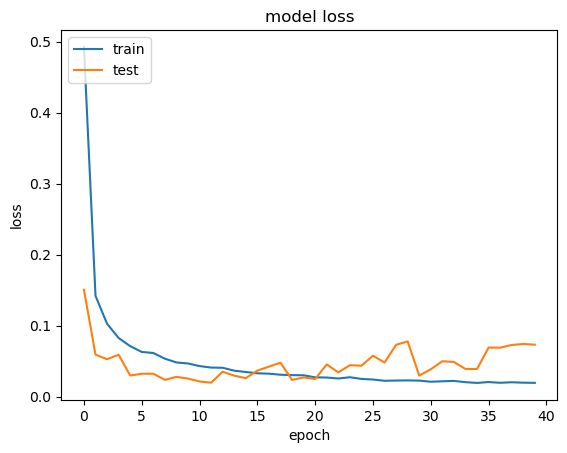

In [27]:
# Training variables
LEARN_RATE = 0.001
OPTIM = Adam(learning_rate=LEARN_RATE)

print('Main variables initialised.')

model2 = create_cnn_model()
model2.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
history2 = model2.fit(X_train, Y_train, batch_size=128, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# Evaluate the model on the test set
test_loss2, test_acc2 = model2.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc2)

# list all data in history
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 3. Adam, 0.0001

Main variables initialised.
Epoch 1/40
 13/500 [..............................] - ETA: 4s - loss: 2.6033 - accuracy: 0.0883

2023-08-30 03:45:14.310251: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 5s 9ms/step - loss: 1.4304 - accuracy: 0.5211 - val_loss: 2.1693 - val_accuracy: 0.1166
Epoch 2/40
500/500 [==============================] - 4s 9ms/step - loss: 0.4688 - accuracy: 0.8556 - val_loss: 1.2583 - val_accuracy: 0.7228
Epoch 3/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3101 - accuracy: 0.9078 - val_loss: 0.7785 - val_accuracy: 0.8777
Epoch 4/40
500/500 [==============================] - 4s 8ms/step - loss: 0.2466 - accuracy: 0.9272 - val_loss: 0.5316 - val_accuracy: 0.8581
Epoch 5/40
500/500 [==============================] - 4s 8ms/step - loss: 0.2075 - accuracy: 0.9367 - val_loss: 0.4112 - val_accuracy: 0.8961
Epoch 6/40
500/500 [==============================] - 4s 8ms/step - loss: 0.1810 - accuracy: 0.9457 - val_loss: 0.3299 - val_accuracy: 0.9134
Epoch 7/40
500/500 [==============================] - 4s 8ms/step - loss: 0.1607 - accuracy: 0.9520 - val_loss: 0.2894 - val_accuracy: 0.9329
Epoch 8/40
500/50

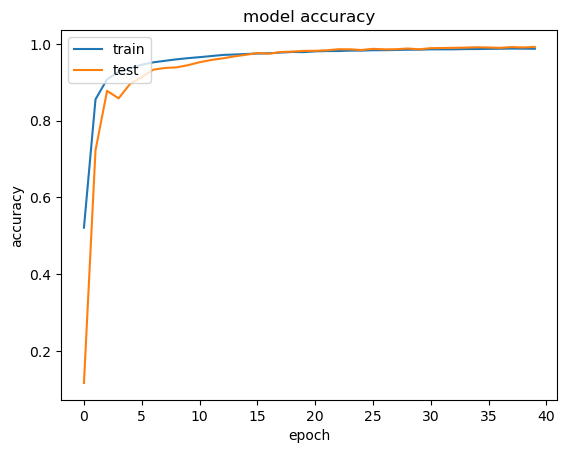

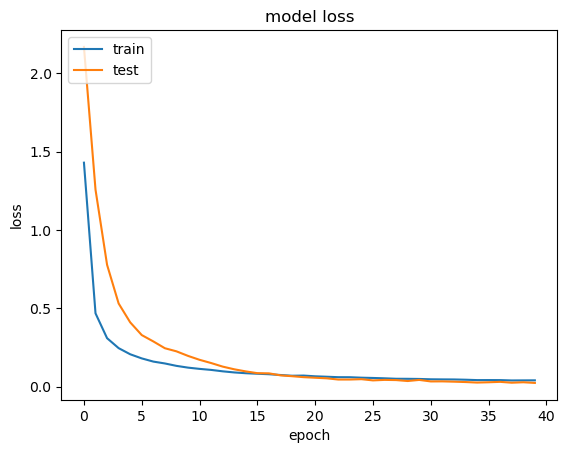

In [28]:
# Training variables
LEARN_RATE = 0.0001
OPTIM = Adam(learning_rate=LEARN_RATE)

print('Main variables initialised.')

model3 = create_cnn_model()
model3.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
history3 = model3.fit(X_train, Y_train, batch_size=128, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# Evaluate the model on the test set
test_loss3, test_acc3 = model3.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc3)

# list all data in history
print(history3.history.keys())
# summarize history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 4. SGD, 0.01

Main variables initialised.
Epoch 1/40
 13/500 [..............................] - ETA: 4s - loss: 2.6379 - accuracy: 0.0739

2023-08-30 03:48:40.214283: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 5s 9ms/step - loss: 2.1896 - accuracy: 0.2522 - val_loss: 3.0434 - val_accuracy: 0.0040
Epoch 2/40
500/500 [==============================] - 4s 8ms/step - loss: 1.0783 - accuracy: 0.6469 - val_loss: 2.4388 - val_accuracy: 0.1198
Epoch 3/40
500/500 [==============================] - 4s 8ms/step - loss: 0.6361 - accuracy: 0.7978 - val_loss: 1.8937 - val_accuracy: 0.2954
Epoch 4/40
500/500 [==============================] - 4s 8ms/step - loss: 0.4753 - accuracy: 0.8507 - val_loss: 1.6730 - val_accuracy: 0.4454
Epoch 5/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3994 - accuracy: 0.8754 - val_loss: 1.4861 - val_accuracy: 0.6258
Epoch 6/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3518 - accuracy: 0.8941 - val_loss: 1.3426 - val_accuracy: 0.6768
Epoch 7/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3176 - accuracy: 0.9053 - val_loss: 1.2226 - val_accuracy: 0.6880
Epoch 8/40
500/50

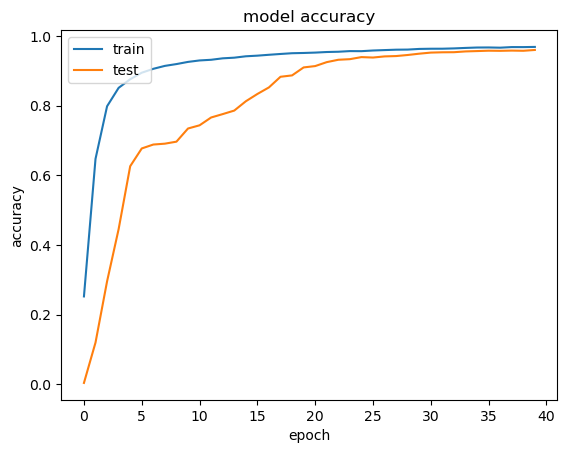

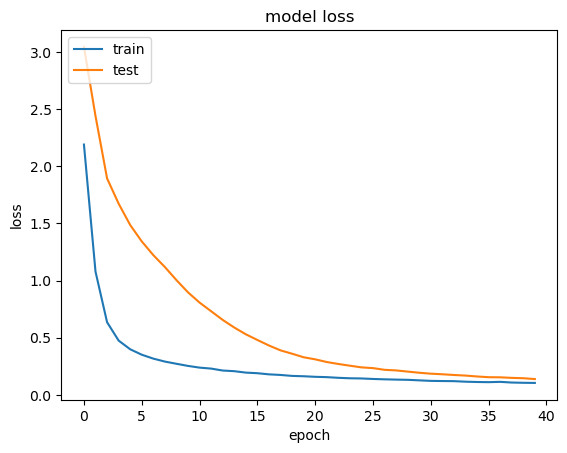

In [29]:
# Training variables
LEARN_RATE = 0.01
OPTIM = SGD(learning_rate=LEARN_RATE)

print('Main variables initialised.')

model4 = create_cnn_model()
model4.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
history4 = model4.fit(X_train, Y_train, batch_size=128, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# Evaluate the model on the test set
test_loss4, test_acc4 = model4.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc4)

# list all data in history
print(history4.history.keys())
# summarize history for accuracy
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 5. SGD, 0.001

Main variables initialised.
Epoch 1/40
 13/500 [..............................] - ETA: 4s - loss: 2.6533 - accuracy: 0.0841

2023-08-30 03:52:05.895953: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 5s 8ms/step - loss: 2.6045 - accuracy: 0.0997 - val_loss: 2.7302 - val_accuracy: 0.0000e+00
Epoch 2/40
500/500 [==============================] - 4s 8ms/step - loss: 2.5263 - accuracy: 0.1133 - val_loss: 2.8347 - val_accuracy: 0.0000e+00
Epoch 3/40
500/500 [==============================] - 4s 9ms/step - loss: 2.4644 - accuracy: 0.1297 - val_loss: 2.9124 - val_accuracy: 0.0000e+00
Epoch 4/40
500/500 [==============================] - 4s 8ms/step - loss: 2.4102 - accuracy: 0.1530 - val_loss: 2.9496 - val_accuracy: 0.0000e+00
Epoch 5/40
500/500 [==============================] - 4s 7ms/step - loss: 2.3502 - accuracy: 0.1803 - val_loss: 2.9659 - val_accuracy: 0.0000e+00
Epoch 6/40
500/500 [==============================] - 4s 8ms/step - loss: 2.2629 - accuracy: 0.2262 - val_loss: 2.9745 - val_accuracy: 0.0000e+00
Epoch 7/40
500/500 [==============================] - 4s 8ms/step - loss: 2.1462 - accuracy: 0.2810 - val_loss: 2.9710 - val_accuracy: 

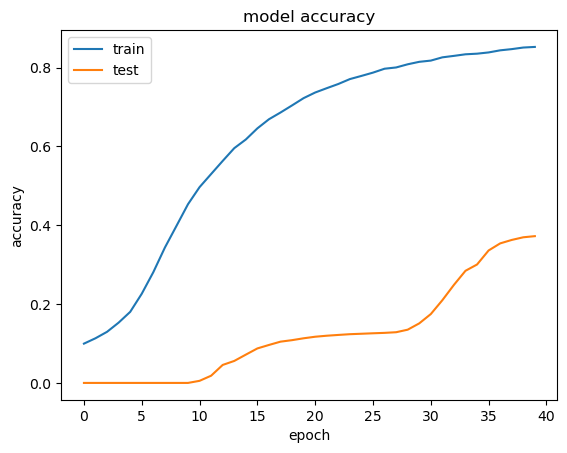

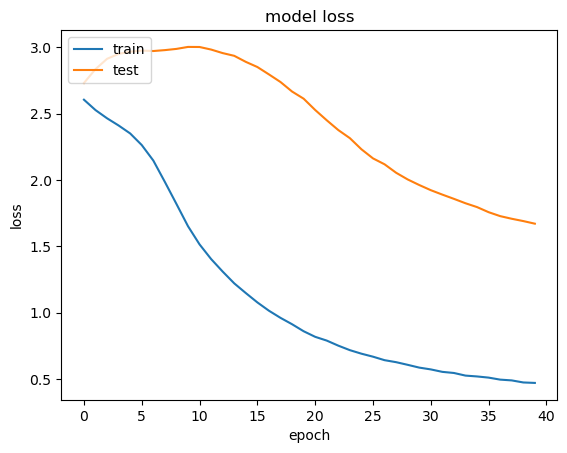

In [30]:
# Training variables
LEARN_RATE = 0.001
OPTIM = SGD(learning_rate=LEARN_RATE)

print('Main variables initialised.')

model5 = create_cnn_model()
model5.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
history5 = model5.fit(X_train, Y_train, batch_size=128, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# Evaluate the model on the test set
test_loss5, test_acc5 = model5.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc5)

# list all data in history
print(history5.history.keys())
# summarize history for accuracy
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 6. SGD, 0.0001

Main variables initialised.
Epoch 1/40
 13/500 [..............................] - ETA: 4s - loss: 2.6555 - accuracy: 0.0823

2023-08-30 03:55:32.100275: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 5s 8ms/step - loss: 2.6515 - accuracy: 0.0764 - val_loss: 2.6257 - val_accuracy: 0.1757
Epoch 2/40
500/500 [==============================] - 4s 8ms/step - loss: 2.6338 - accuracy: 0.0870 - val_loss: 2.6385 - val_accuracy: 0.0676
Epoch 3/40
500/500 [==============================] - 4s 8ms/step - loss: 2.6209 - accuracy: 0.0926 - val_loss: 2.6504 - val_accuracy: 0.0078
Epoch 4/40
500/500 [==============================] - 4s 8ms/step - loss: 2.6085 - accuracy: 0.0979 - val_loss: 2.6618 - val_accuracy: 1.2500e-04
Epoch 5/40
500/500 [==============================] - 4s 8ms/step - loss: 2.5973 - accuracy: 0.1000 - val_loss: 2.6730 - val_accuracy: 0.0000e+00
Epoch 6/40
500/500 [==============================] - 4s 8ms/step - loss: 2.5853 - accuracy: 0.1045 - val_loss: 2.6841 - val_accuracy: 0.0000e+00
Epoch 7/40
500/500 [==============================] - 4s 9ms/step - loss: 2.5747 - accuracy: 0.1064 - val_loss: 2.6953 - val_accuracy: 0.0000e+00
E

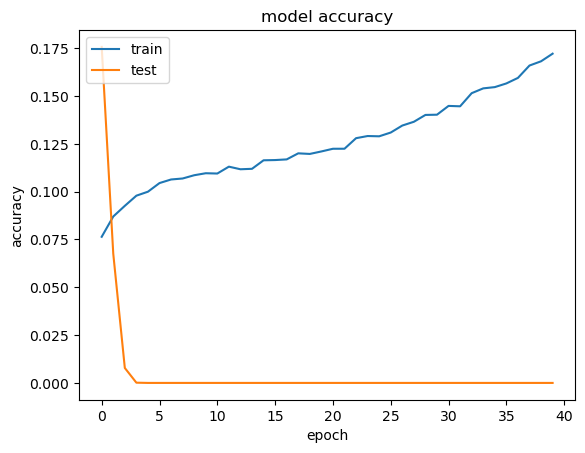

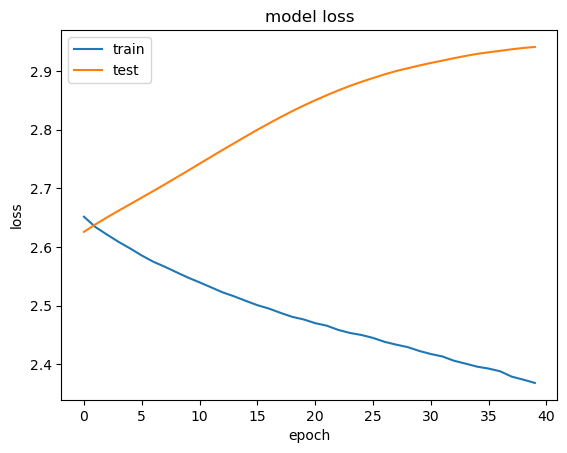

In [31]:
# Training variables
LEARN_RATE = 0.0001
OPTIM = SGD(learning_rate=LEARN_RATE)

print('Main variables initialised.')

model6 = create_cnn_model()
model6.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
history6 = model6.fit(X_train, Y_train, batch_size=128, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# Evaluate the model on the test set
test_loss6, test_acc6 = model6.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc6)

# list all data in history
print(history6.history.keys())
# summarize history for accuracy
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history6.history['loss'])
plt.plot(history6.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 7. RMSprop, 0.01

Main variables initialised.
Epoch 1/40
  7/500 [..............................] - ETA: 4s - loss: 7.7621 - accuracy: 0.0993  

2023-08-30 03:58:58.234094: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 5s 9ms/step - loss: 0.6061 - accuracy: 0.8319 - val_loss: 0.3870 - val_accuracy: 0.8786
Epoch 2/40
500/500 [==============================] - 4s 8ms/step - loss: 0.2441 - accuracy: 0.9356 - val_loss: 0.3079 - val_accuracy: 0.8712
Epoch 3/40
500/500 [==============================] - 5s 9ms/step - loss: 0.2594 - accuracy: 0.9345 - val_loss: 0.1107 - val_accuracy: 0.9675
Epoch 4/40
500/500 [==============================] - 4s 8ms/step - loss: 0.2857 - accuracy: 0.9315 - val_loss: 0.2542 - val_accuracy: 0.8904
Epoch 5/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3125 - accuracy: 0.9264 - val_loss: 0.2010 - val_accuracy: 0.9309
Epoch 6/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3403 - accuracy: 0.9225 - val_loss: 0.2702 - val_accuracy: 0.8744
Epoch 7/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3434 - accuracy: 0.9211 - val_loss: 0.3130 - val_accuracy: 0.9029
Epoch 8/40
500/50

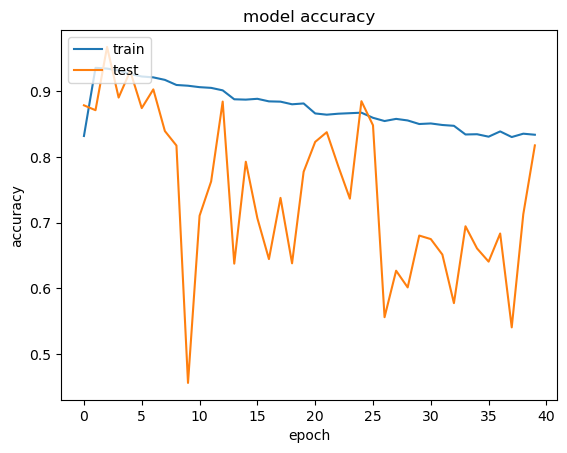

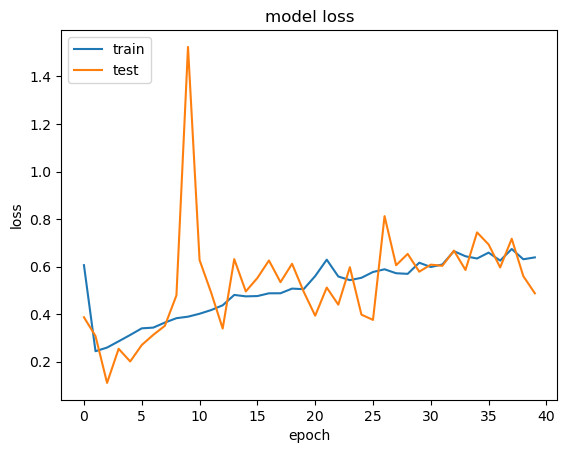

In [32]:
# Training variables
LEARN_RATE = 0.01
OPTIM = RMSprop(learning_rate=LEARN_RATE)

print('Main variables initialised.')

model7 = create_cnn_model()
model7.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
history7 = model7.fit(X_train, Y_train, batch_size=128, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# Evaluate the model on the test set
test_loss7, test_acc7 = model7.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc7)

# list all data in history
print(history7.history.keys())
# summarize history for accuracy
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 8. RMSprop, 0.001

Main variables initialised.
Epoch 1/40
  1/500 [..............................] - ETA: 12:11 - loss: 2.6856 - accuracy: 0.0625

2023-08-30 04:01:49.471913: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/dropout_32/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 6s 9ms/step - loss: 0.4271 - accuracy: 0.8666 - val_loss: 0.1592 - val_accuracy: 0.9427
Epoch 2/40
500/500 [==============================] - 4s 8ms/step - loss: 0.1134 - accuracy: 0.9657 - val_loss: 0.1520 - val_accuracy: 0.9368
Epoch 3/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0793 - accuracy: 0.9771 - val_loss: 0.0832 - val_accuracy: 0.9656
Epoch 4/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0678 - accuracy: 0.9800 - val_loss: 0.1133 - val_accuracy: 0.9617
Epoch 5/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0569 - accuracy: 0.9834 - val_loss: 0.0643 - val_accuracy: 0.9761
Epoch 6/40
500/500 [==============================] - 4s 8ms/step - loss: 0.0536 - accuracy: 0.9842 - val_loss: 0.0804 - val_accuracy: 0.9756
Epoch 7/40
500/500 [==============================] - 4s 9ms/step - loss: 0.0481 - accuracy: 0.9863 - val_loss: 0.0662 - val_accuracy: 0.9818
Epoch 8/40
500/50

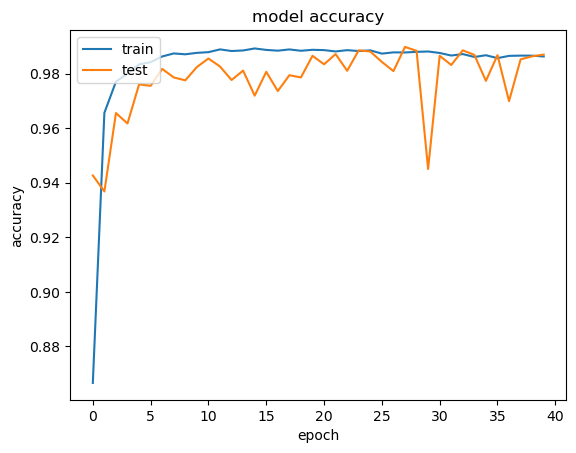

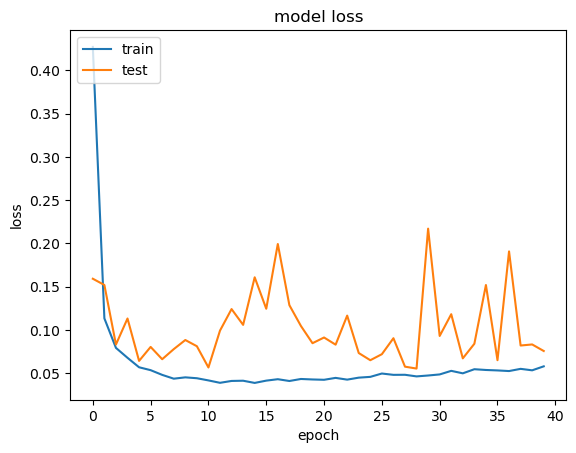

In [33]:
# Training variables
LEARN_RATE = 0.001
OPTIM = RMSprop(learning_rate=LEARN_RATE)

print('Main variables initialised.')

model8 = create_cnn_model()
model8.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
history8 = model8.fit(X_train, Y_train, batch_size=128, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# Evaluate the model on the test set
test_loss8, test_acc8 = model8.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc8)

# list all data in history
print(history8.history.keys())
# summarize history for accuracy
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### 9. RMSprop, 0.0001

Main variables initialised.
Epoch 1/40
  7/500 [..............................] - ETA: 4s - loss: 2.5899 - accuracy: 0.1060  

2023-08-30 04:04:41.966611: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


500/500 [==============================] - 5s 9ms/step - loss: 1.5046 - accuracy: 0.5015 - val_loss: 2.4179 - val_accuracy: 0.1087
Epoch 2/40
500/500 [==============================] - 4s 9ms/step - loss: 0.5532 - accuracy: 0.8274 - val_loss: 1.3496 - val_accuracy: 0.5989
Epoch 3/40
500/500 [==============================] - 4s 8ms/step - loss: 0.3384 - accuracy: 0.8991 - val_loss: 0.8304 - val_accuracy: 0.6969
Epoch 4/40
500/500 [==============================] - 4s 9ms/step - loss: 0.2521 - accuracy: 0.9241 - val_loss: 0.5531 - val_accuracy: 0.7452
Epoch 5/40
500/500 [==============================] - 4s 9ms/step - loss: 0.2137 - accuracy: 0.9358 - val_loss: 0.4209 - val_accuracy: 0.8029
Epoch 6/40
500/500 [==============================] - 4s 8ms/step - loss: 0.1828 - accuracy: 0.9447 - val_loss: 0.3456 - val_accuracy: 0.8709
Epoch 7/40
500/500 [==============================] - 4s 8ms/step - loss: 0.1617 - accuracy: 0.9508 - val_loss: 0.2885 - val_accuracy: 0.9058
Epoch 8/40
500/50

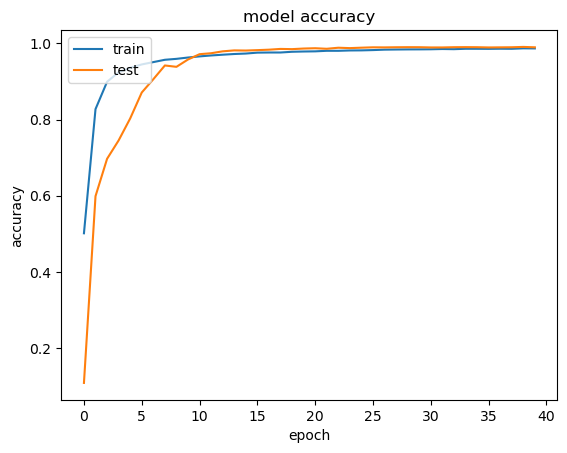

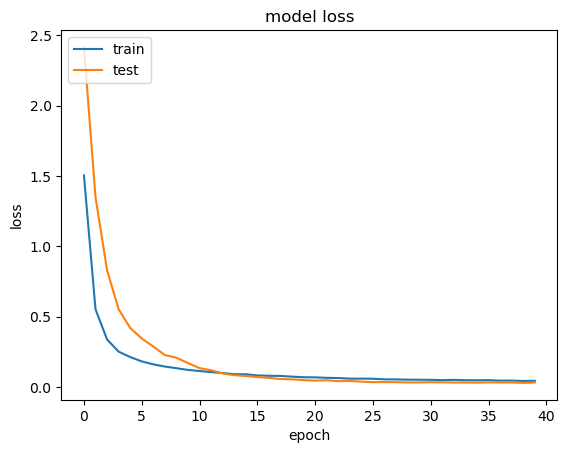

In [34]:
# Training variables
LEARN_RATE = 0.0001
OPTIM = RMSprop(learning_rate=LEARN_RATE)

print('Main variables initialised.')

model9 = create_cnn_model()
model9.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
history9 = model9.fit(X_train, Y_train, batch_size=128, epochs=N_EPOCH, verbose=VERBOSE, validation_split=VALIDATION_SPLIT)

# Evaluate the model on the test set
test_loss9, test_acc9 = model9.evaluate(X_test, Y_test)
print('Test accuracy:', test_acc9)

# list all data in history
print(history9.history.keys())
# summarize history for accuracy
plt.plot(history9.history['accuracy'])
plt.plot(history9.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history9.history['loss'])
plt.plot(history9.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Predictions of top 3

In [35]:
# Function to make predictions on a single sample image
def predict_single_image(model, sample_image):
    sample_image = np.array(sample_image).reshape(1, 28, 28, 1).astype('float32') / 255.0
    prediction = model.predict(sample_image)[0]
    predicted_label = np.argmax(prediction)
    confidence_percentage = np.max(prediction) * 100
    return predicted_label, confidence_percentage

1/1 [==============================] - 0s 31ms/step


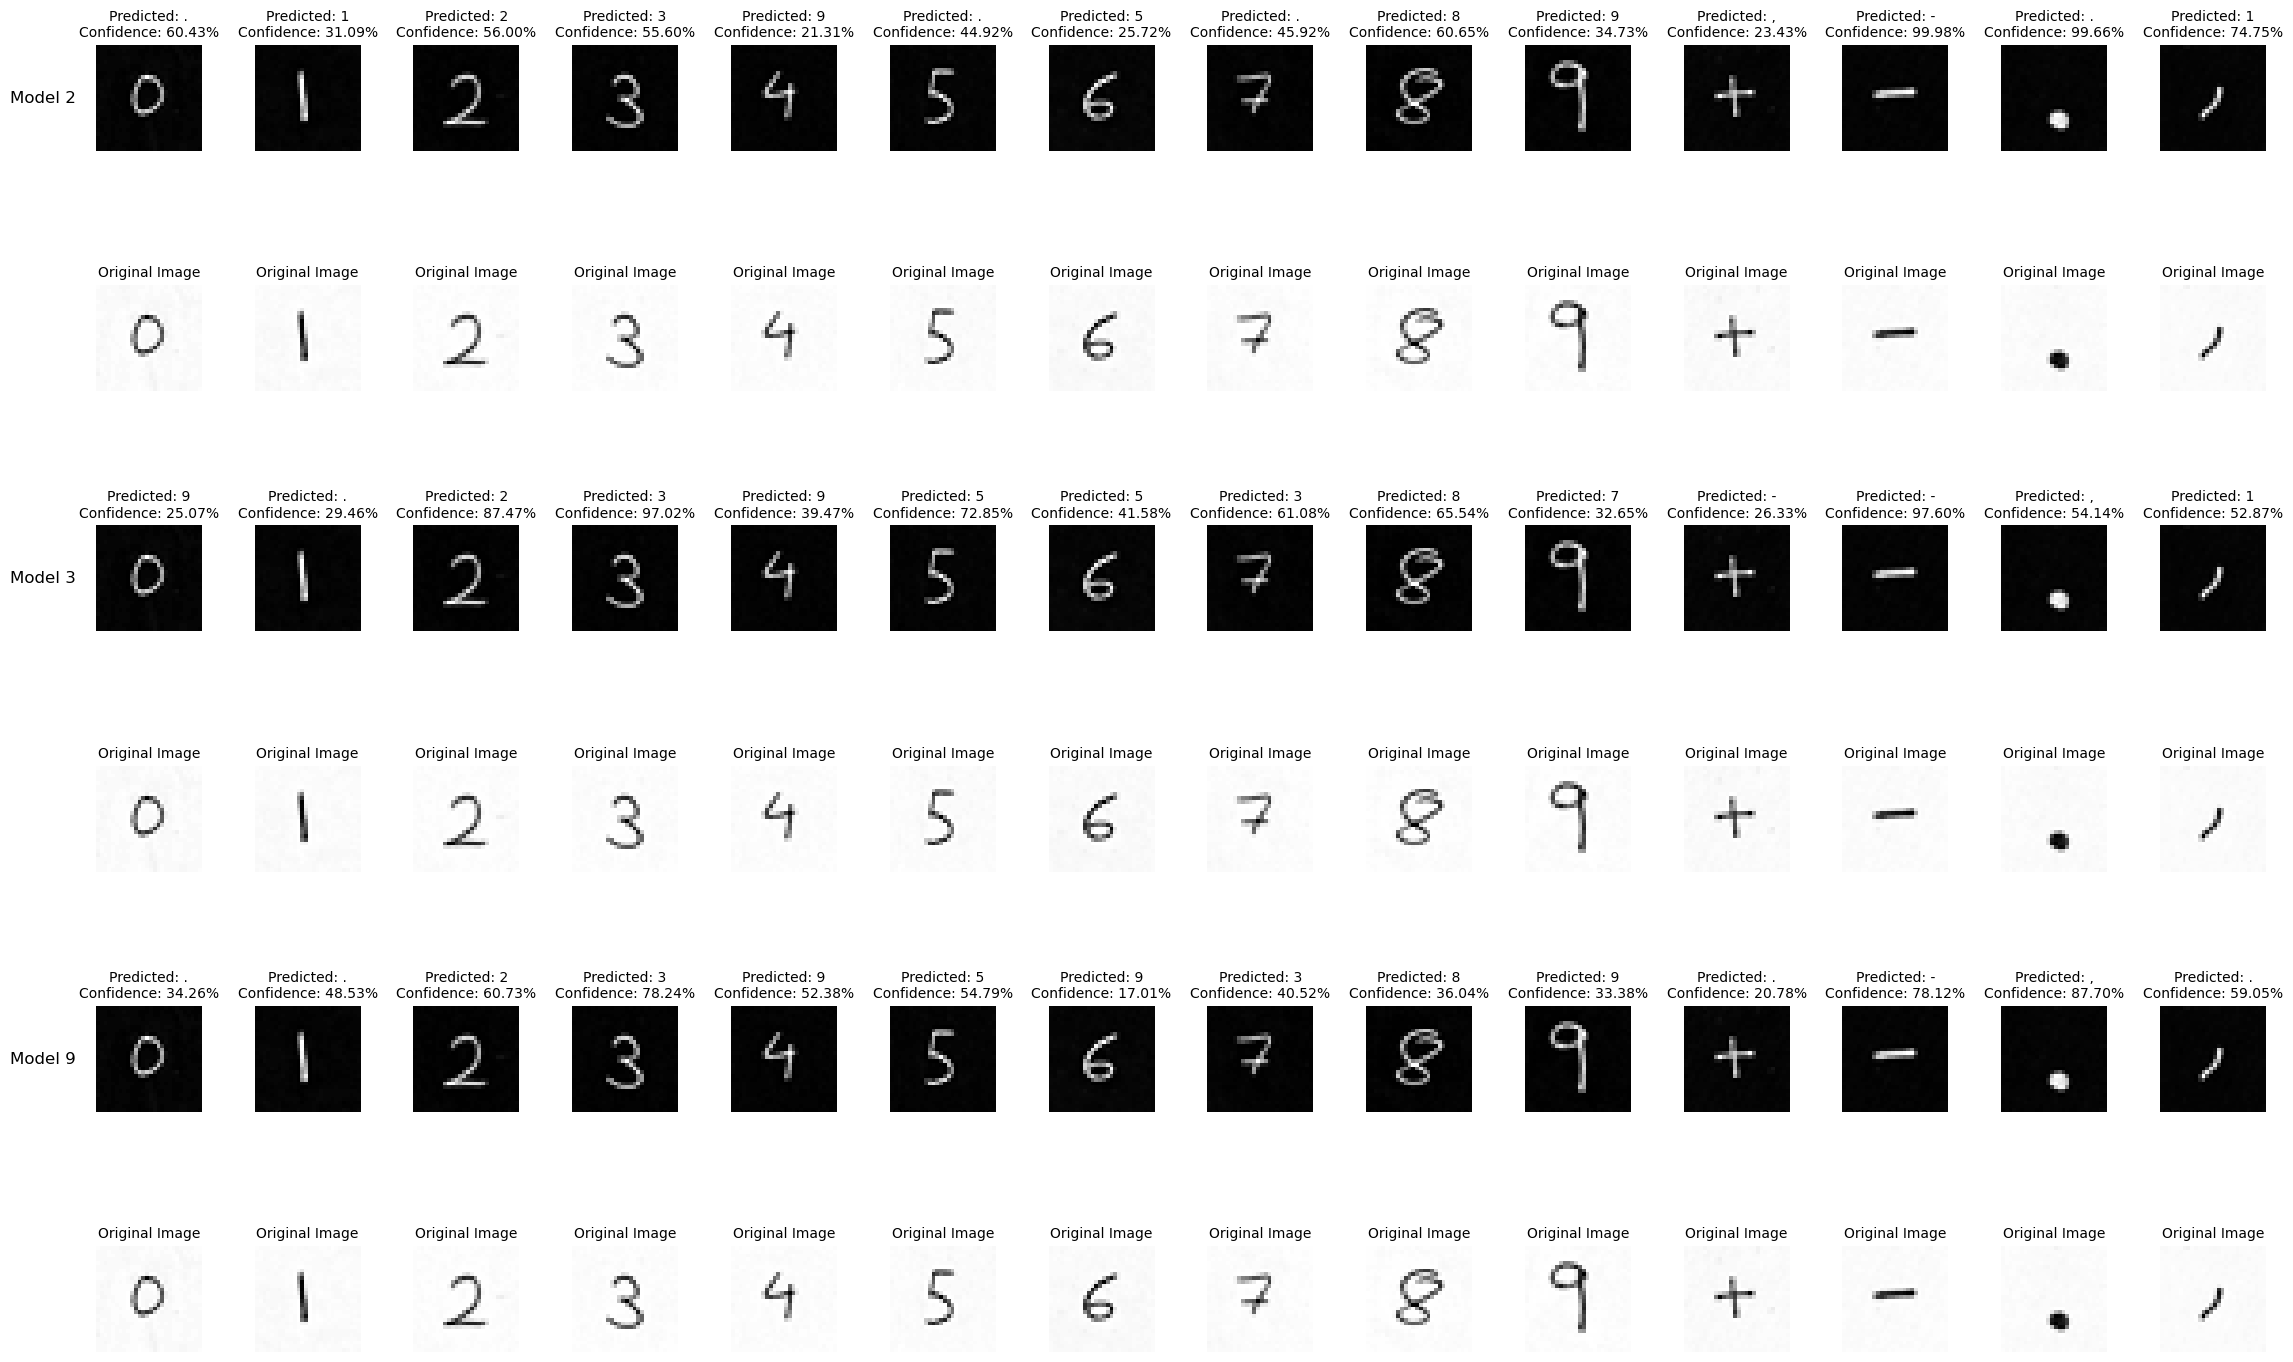

In [39]:
# Function to map predicted labels to punctuation marks
def map_to_punctuation(predicted_label):
    if predicted_label == 10:
        return '+'
    elif predicted_label == 11:
        return '-'
    elif predicted_label == 12:
        return '.'
    elif predicted_label == 13:
        return ','
    else:
        return str(predicted_label)

# Sample images for prediction
sample_image_paths = [
    "/kaggle/input/single-digits/0.png",
    "/kaggle/input/single-digits/1.png",
    "/kaggle/input/single-digits/2.png",
    "/kaggle/input/single-digits/3.png",
    "/kaggle/input/single-digits/4.png",
    "/kaggle/input/single-digits/5.png",
    "/kaggle/input/single-digits/6.png",
    "/kaggle/input/single-digits/7.png",
    "/kaggle/input/single-digits/8.png",
    "/kaggle/input/single-digits/9.png",
    "/kaggle/input/single-digits/10.png", 
    "/kaggle/input/single-digits/11.png",  
    "/kaggle/input/single-digits/12.png",  
    "/kaggle/input/single-digits/13.png", 
]

# List of models
models_list = [model2, model3, model9] 

# Model names corresponding to the models in models_list
model_names = ["Model 2", "Model 3", "Model 9"]

# Set the common figure size for all images and number of columns for the subplot
num_images = len(sample_image_paths)
num_models = len(models_list)
fig, axs = plt.subplots(num_models * 2, num_images, figsize=(num_images * 2, num_models * 6))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.3)

# Call the function to display each image with its prediction
for j, model in enumerate(models_list):
    for i, image_path in enumerate(sample_image_paths):
        # Load and preprocess the image
        sample_image = Image.open(image_path).convert("L")  # Convert to grayscale
        sample_image = sample_image.resize((28, 28))  # Resize to MNIST image size (28x28)

        # Convert to black background with white digit
        sample_image_array = 255 - np.array(sample_image)

        # Make predictions on the enhanced image
        predicted_label, confidence_percentage = predict_single_image(model, sample_image_array)
        
        # Map the predicted label to punctuation if applicable
        predicted_label_mapped = map_to_punctuation(predicted_label)

        # Display the enhanced image with black background and clearer white digit
        axs[j * 2, i].imshow(sample_image_array, cmap='gray')
        axs[j * 2, i].set_title(f"Predicted: {predicted_label_mapped}\nConfidence: {confidence_percentage:.2f}%", fontsize=10)
        axs[j * 2, i].axis('off')

        # Display the original image below the enhanced image
        axs[j * 2 + 1, i].imshow(sample_image, cmap='gray')
        axs[j * 2 + 1, i].set_title("Original Image", fontsize=10)
        axs[j * 2 + 1, i].axis('off')
        
    # Adding correct model name as a title to the left of the rows
    axs[j * 2, 0].annotate(model_names[j], xy=(-0.5, 0.5), xycoords='axes fraction', va='center', ha='center', fontsize=12)

# Rotate x-axis tick labels to accommodate longer text
for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.show()


#### Prediction of top 3 with enhancement

In [40]:
# Function to make predictions on a single sample image
def predict_single_image(model, sample_image):
    sample_image = np.array(sample_image).reshape(1, 28, 28, 1).astype('float32') / 255.0
    prediction = model.predict(sample_image)[0]
    predicted_label = np.argmax(prediction)
    confidence_percentage = np.max(prediction) * 100
    return predicted_label, confidence_percentage

# Function to enhance the image (increase contrast and brightness)
def enhance_image(sample_image_array):
    enhancer = ImageEnhance.Contrast(Image.fromarray(sample_image_array))
    enhanced_image_array = np.array(enhancer.enhance(2.0))  # Increase contrast 
    return enhanced_image_array

1/1 [==============================] - 0s 27ms/step


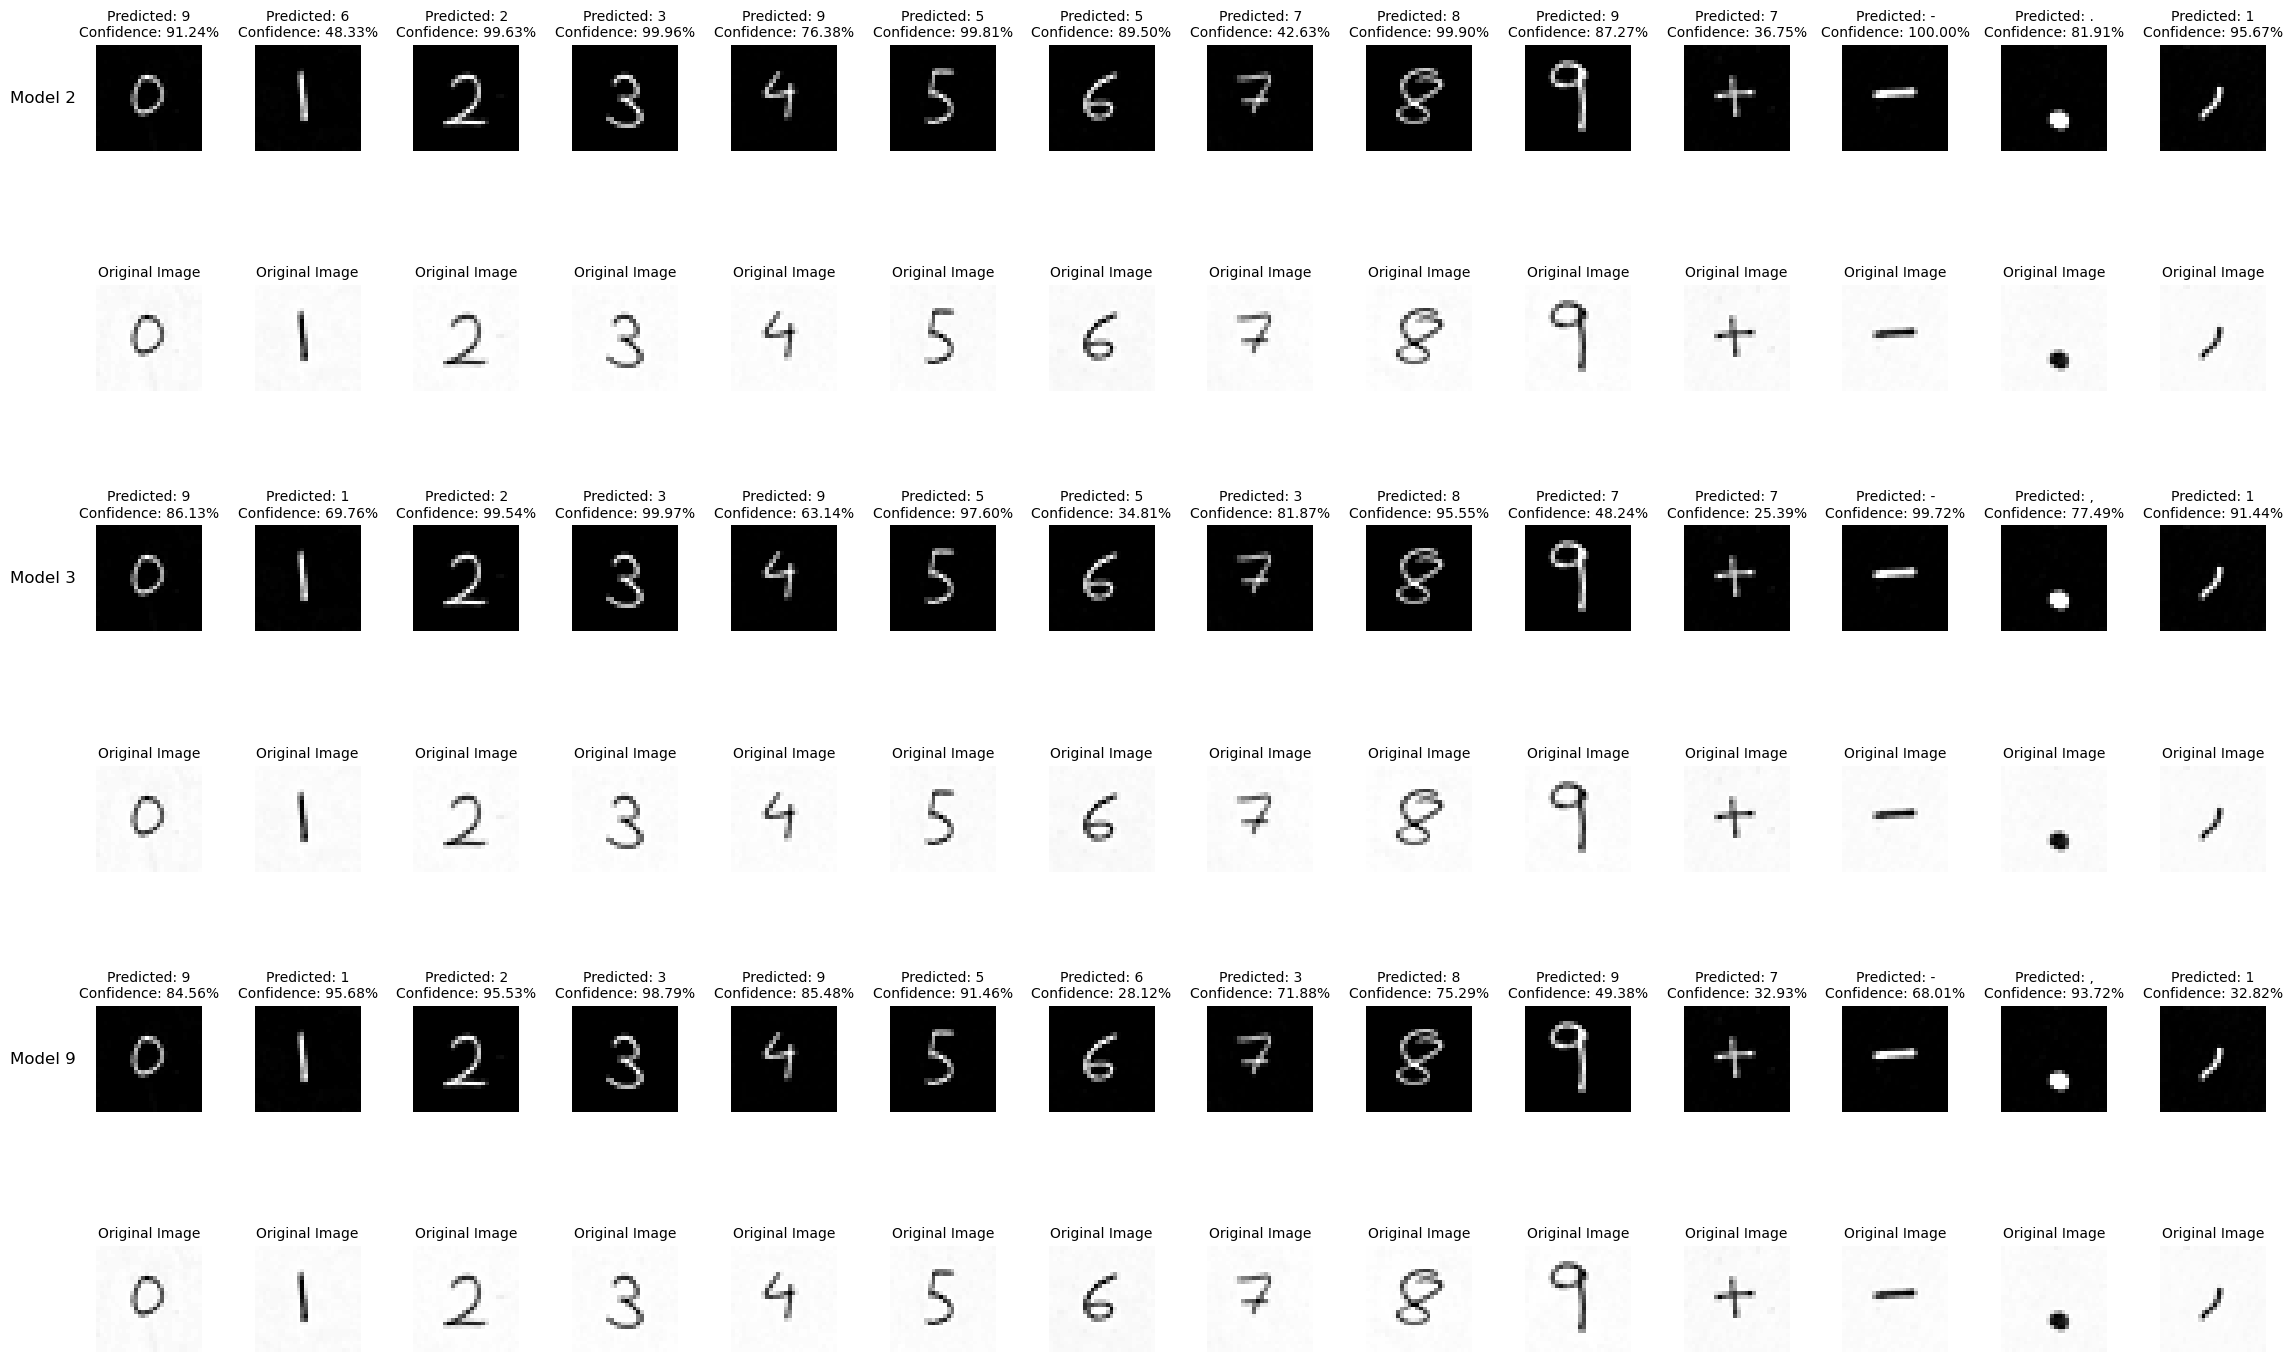

In [41]:
# Sample images for prediction
sample_image_paths = [
    "/kaggle/input/single-digits/0.png",
    "/kaggle/input/single-digits/1.png",
    "/kaggle/input/single-digits/2.png",
    "/kaggle/input/single-digits/3.png",
    "/kaggle/input/single-digits/4.png",
    "/kaggle/input/single-digits/5.png",
    "/kaggle/input/single-digits/6.png",
    "/kaggle/input/single-digits/7.png",
    "/kaggle/input/single-digits/8.png",
    "/kaggle/input/single-digits/9.png",
    "/kaggle/input/single-digits/10.png", 
    "/kaggle/input/single-digits/11.png",  
    "/kaggle/input/single-digits/12.png",  
    "/kaggle/input/single-digits/13.png", 
]

# List of models
models_list = [model2, model3, model9]  # Replace with your actual models

# Set the common figure size for all images and number of columns for the subplot
num_images = len(sample_image_paths)
num_models = len(models_list)
fig, axs = plt.subplots(num_models * 2, num_images, figsize=(num_images * 2, num_models * 6))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.3)

# Call the function to display each image with its prediction
for j, model in enumerate(models_list):
    for i, image_path in enumerate(sample_image_paths):
        sample_image = Image.open(image_path).convert("L")
        sample_image = sample_image.resize((28, 28))
        sample_image_array = 255 - np.array(sample_image)
        enhanced_image_array = enhance_image(sample_image_array)
        
        predicted_label, confidence_percentage = predict_single_image(model, enhanced_image_array)
        predicted_label_mapped = map_to_punctuation(predicted_label)

        axs[j * 2, i].imshow(enhanced_image_array, cmap='gray')
        axs[j * 2, i].set_title(f"Predicted: {predicted_label_mapped}\nConfidence: {confidence_percentage:.2f}%", fontsize=10)
        axs[j * 2, i].axis('off')

        axs[j * 2 + 1, i].imshow(sample_image, cmap='gray')
        axs[j * 2 + 1, i].set_title("Original Image", fontsize=10)
        axs[j * 2 + 1, i].axis('off')
        
    # Adding correct model name as a title to the left of the rows
    axs[j * 2, 0].annotate(model_names[j], xy=(-0.5, 0.5), xycoords='axes fraction', va='center', ha='center', fontsize=12)

# Rotate x-axis tick labels to accommodate longer text
for ax in axs.flat:
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

plt.show()


In [42]:
model9.save('my_best_model2.h5')

1/1 [==============================] - 0s 86ms/step


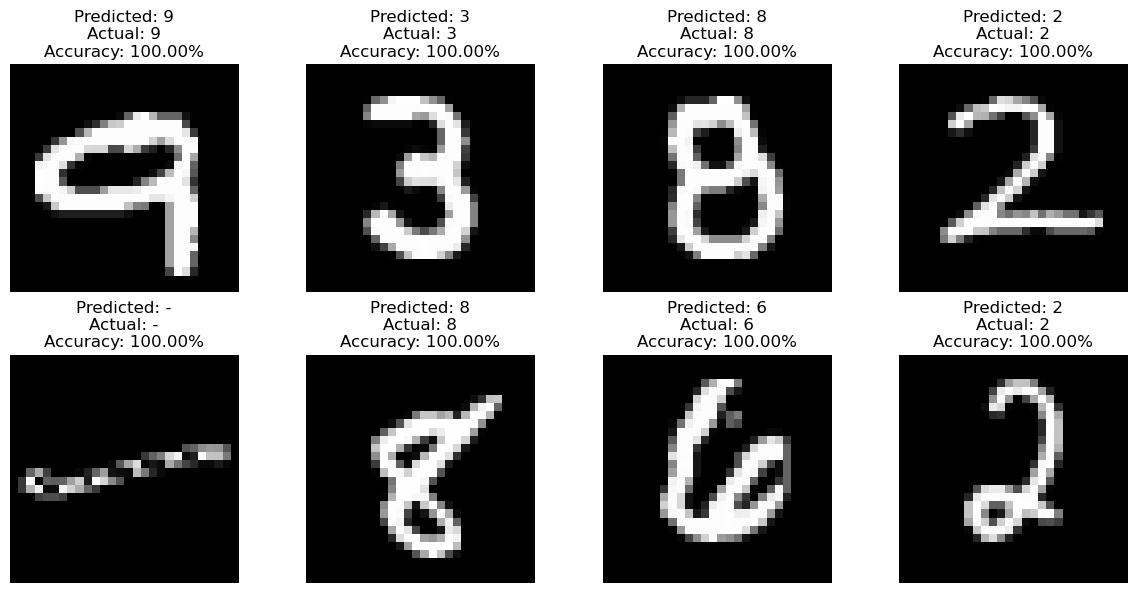

In [44]:
# Select random sample images
num_samples = 8
random_indices_test = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[random_indices_test]
sample_labels = Y_test[random_indices_test]

# Reshape sample_images to match the expected input shape
sample_images_reshaped = sample_images.reshape(num_samples, 28, 28, 1)

# Predict labels for sample images
predictions = model9.predict(sample_images_reshaped)
predicted_labels = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to actual labels
actual_labels = np.argmax(sample_labels, axis=1)

# Define label names
label_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '.', ',']

# Calculate accuracy for each image
accuracies = np.equal(predicted_labels, actual_labels)
accuracy_percentage = np.mean(accuracies) * 100

# Display sample images with predicted and actual labels and accuracies
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(num_samples):
    axes[i].imshow(sample_images[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Predicted: {label_names[predicted_labels[i]]}\nActual: {label_names[actual_labels[i]]}\nAccuracy: {accuracy_percentage:.2f}%')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
